In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import cv2

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomBrightness, Rescaling
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import EfficientNetB0, DenseNet121

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from scipy import ndimage

## [A] EDA

In [2]:
def load_images_from_directory(base_dir):
    image_data = []
    labels = []
    file_paths = []

    for root, dirs, files in os.walk(base_dir):
        # Skip the root directory itself
        if root == base_dir:
            continue

        # Extract the label from the folder name
        label = os.path.basename(root)

        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                print(f"Processing image: {img_path}")

                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)

                image_data.append(img_array)
                labels.append(label)
                file_paths.append(img_path)

    return image_data, labels, file_paths

In [3]:
image_data, labels, file_paths = load_images_from_directory("C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/train")

Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/train\Doubtful\1_Doubtful_1 (2).png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/train\Doubtful\1_Doubtful_1.png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/train\Doubtful\1_Doubtful_10 (2).png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/train\Doubtful\1_Doubtful_10.png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/train\Doubtful\1_Doubtful_100 (2).png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/train\Doubtful\1_Doubtful_100.png
Processing image: C:/Users/U

In [4]:
df = pd.DataFrame({
    'image': list(image_data),  # Images as arrays
    'label': labels,            # Filenames for images
    'file_path': file_paths     # File paths for images
})

In [5]:
df.shape

(5375, 3)

### Data Visualization

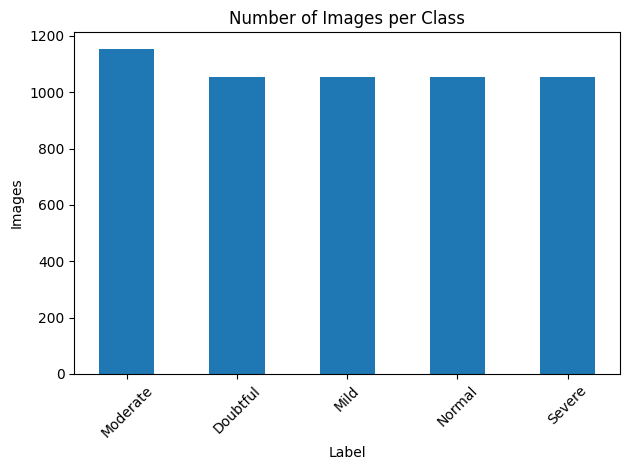

In [8]:
# Group by the 'label' column and count the number of images per class
class_counts = df['label'].value_counts()

# Plotting the number of images per class
plt.bar(class_counts.index, class_counts.values, width=0.5)
plt.title("Number of Images per Class")
plt.xlabel('Label')
plt.ylabel('Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

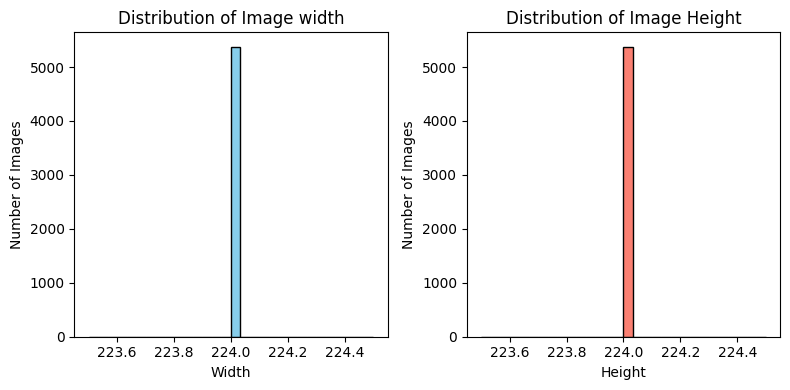

In [9]:
# Extract the dimensions (height and width) of each image
image_dims = [img.shape[:2] for img in df['image']]  # Extract height and width (shape[:2] for each image)
height, width = zip(*image_dims)  # Separate into two lists: height and width

# Plotting distribution of width and height
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plotting width
ax[0].hist(width, bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Distribution of Image width')
ax[0].set_xlabel('Width')
ax[0].set_ylabel('Number of Images')

# Plotting height
ax[1].hist(height, bins=30, color='salmon', edgecolor='black')
ax[1].set_title('Distribution of Image Height')
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [10]:
def show_image_samples(df):
    '''Display one image from each class in a 2x3 grid using the DataFrame'''
    # Get the unique labels (class names)
    unique_labels = df['label'].unique()
    
    ncols = 3  # Set the number of columns in the grid
    nrows = 2  # Set the number of rows in the grid (2x3 grid)
    
    # Set up the plot
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.flatten()

    # Loop through each class and plot one image
    for i, label in enumerate(unique_labels):
        # Filter the dataframe to get the first image for each label
        class_images = df[df['label'] == label]
        img_array = class_images['image'].iloc[0]  # Take the first image in the class
        
        # Plot the image on the corresponding subplot
        axes[i].imshow(img_array.astype('uint8'))  # Ensure the image is in uint8 format for display
        axes[i].set_title(f'{label}')  # Set the title as the class name
        axes[i].axis('off')  # Hide axes

    # Turn off any unused axes (if there are fewer classes than subplots)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

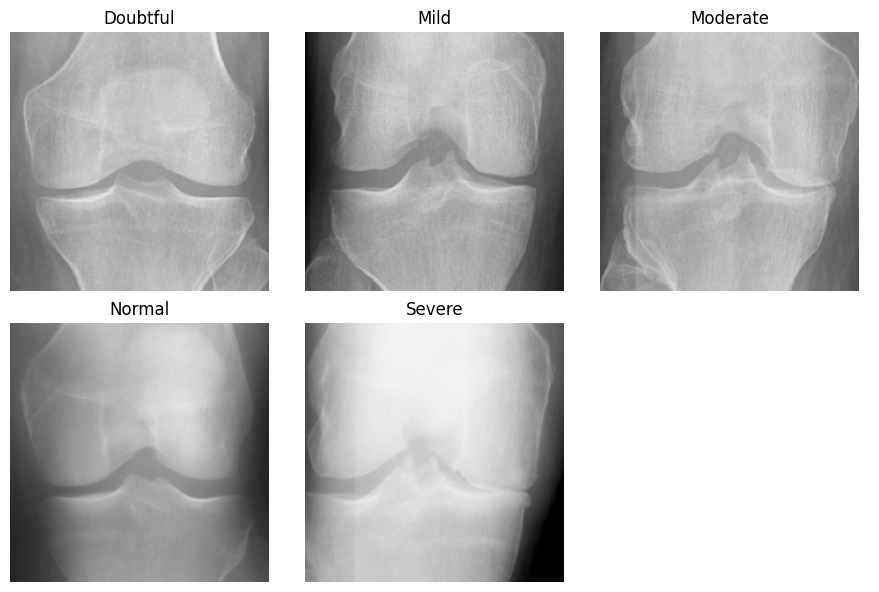

In [11]:
# Call the function to show one image from each class in a grid
show_image_samples(df)

In [12]:
def plot_histogram_from_df(df, index):
    '''Plot histogram from the image stored in the DataFrame at the given index'''
    # Get the image array from the dataframe
    image = df['image'].iloc[index]

    # Ensure the image is in the correct format (0-255)
    # image = np.array(image) * 255  # Rescale if needed (assuming the image was normalized)
    # print(image)

    # Check the shape and convert the image to uint8 for display if needed
    image = image.astype(np.uint8)

    # Separate the image into R, G, and B channels
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    # Create subplots for each channel histogram
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['r', 'g', 'b']
    channel_names = ['Red', 'Green', 'Blue']

    # Loop through each channel and plot its histogram
    for i, channel in enumerate([red_channel, green_channel, blue_channel]):
        axes[i].hist(channel.ravel(), bins=256, color=colors[i], alpha=0.7)
        axes[i].set_title(f"{channel_names[i]} Channel Histogram")
        axes[i].set_xlabel('Pixel Value')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim([0, 256])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


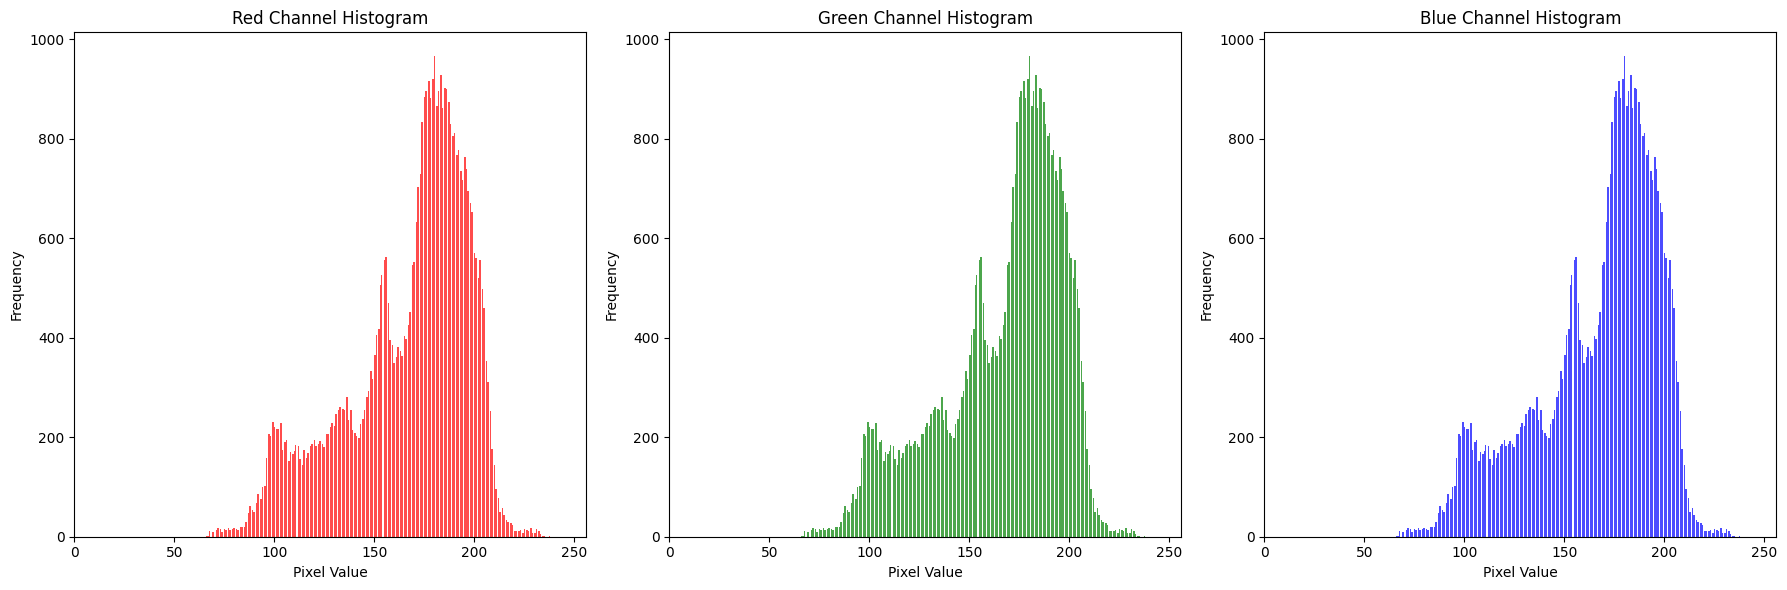

In [13]:
# Example: plot histogram for the first image in the DataFrame
plot_histogram_from_df(df, 0)

Karena gambar grayscale sehingga ketiga channel RGB mempunyai nilai yang sama persis

In [14]:
def plot_histograms_for_class(df, label, num_images=3):
    '''Plot histograms for a subset of grayscale images in the given class (default 3 images)'''
    # Filter images for the current class
    class_images = df[df['label'] == label]['image']
    
    # Limit the number of images plotted to avoid slow rendering
    class_images = class_images.head(num_images)  # Display only the first 'num_images'
    
    # Create subplots to visualize multiple histograms
    fig, axes = plt.subplots(1, len(class_images), figsize=(15, 5))
    if len(class_images) == 1:  # For a single image, axes won't be an array
        axes = [axes]
    
    # Loop through each image in the class and plot its histogram
    for i, img_array in enumerate(class_images):
        # Since it's grayscale, we can use just the image itself (it will have only one channel)
        axes[i].hist(img_array.ravel(), bins=256, color='black', alpha=0.7)
        
        axes[i].set_title(f"{label} - Image {i+1}")
        axes[i].set_xlabel('Pixel Value')
        axes[i].set_ylabel('Frequency')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


Plotting histograms for class: Doubtful


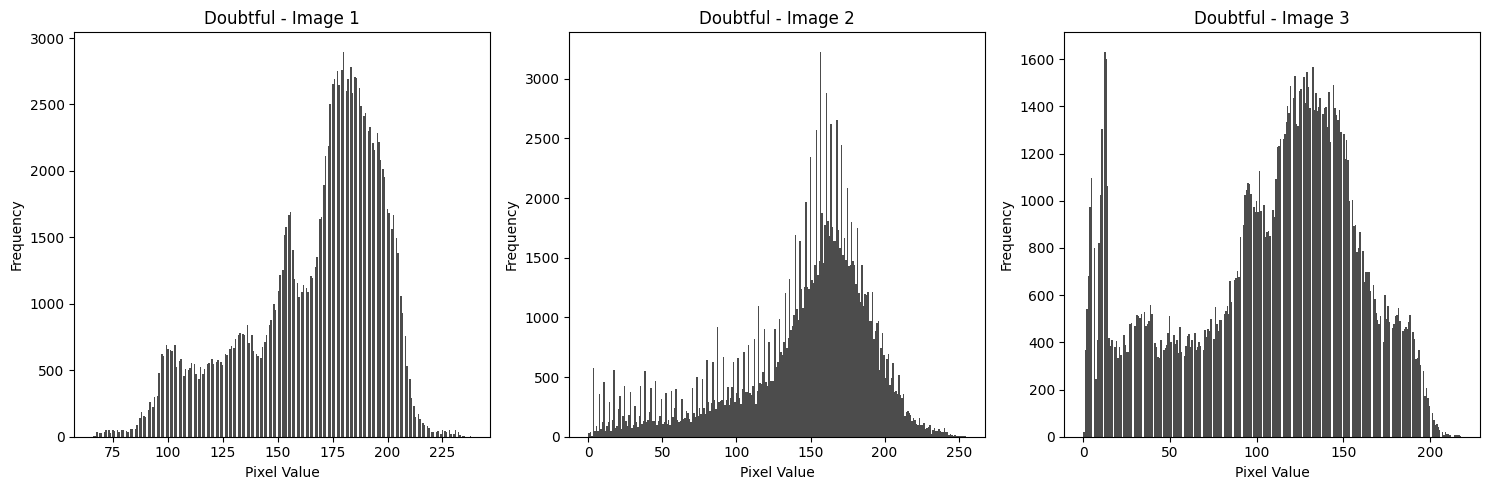

Plotting histograms for class: Mild


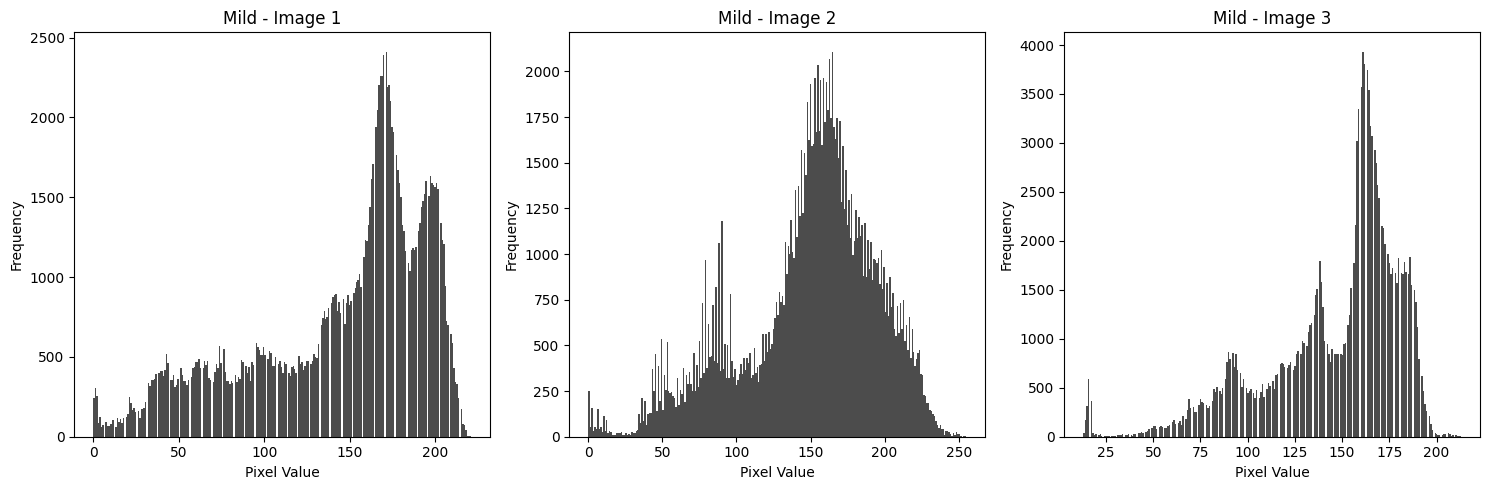

Plotting histograms for class: Moderate


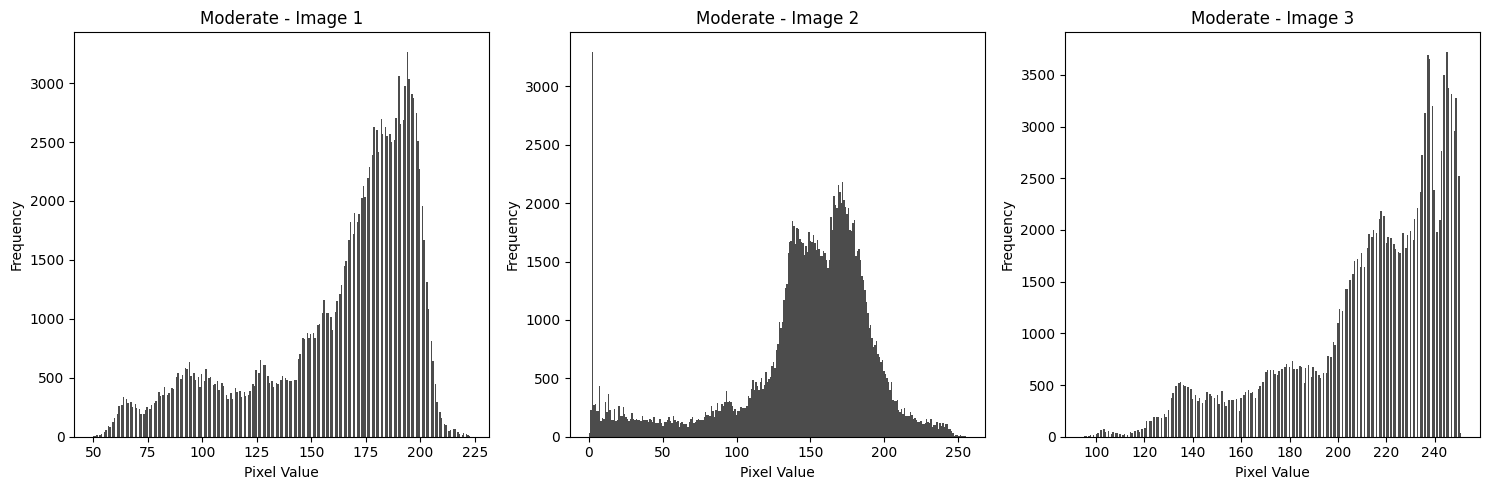

Plotting histograms for class: Normal


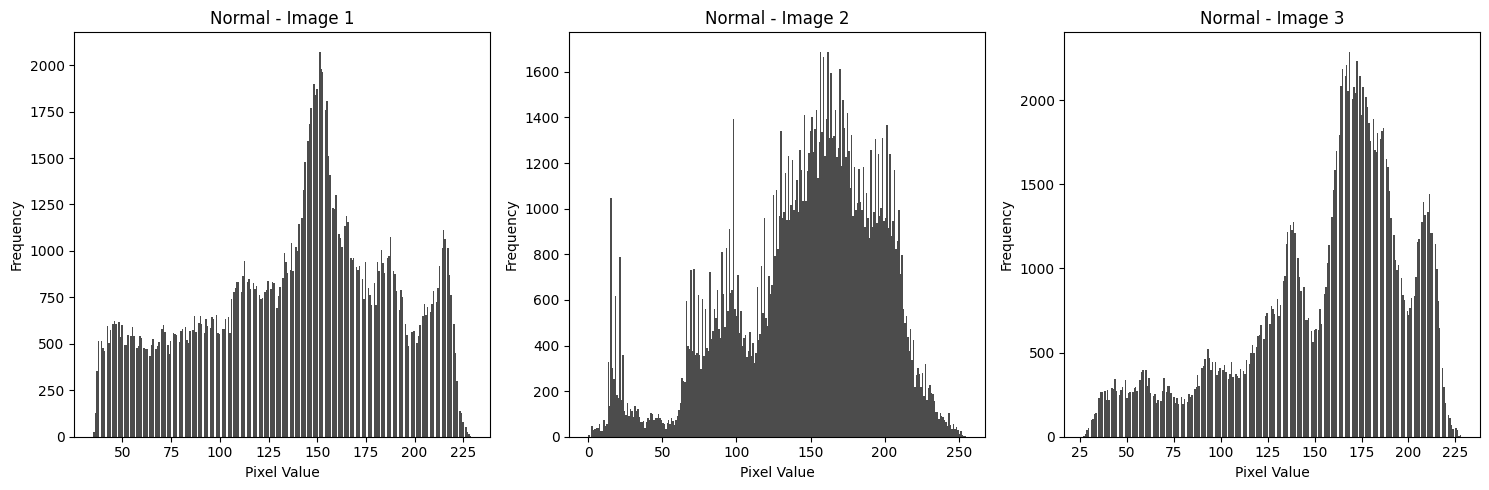

Plotting histograms for class: Severe


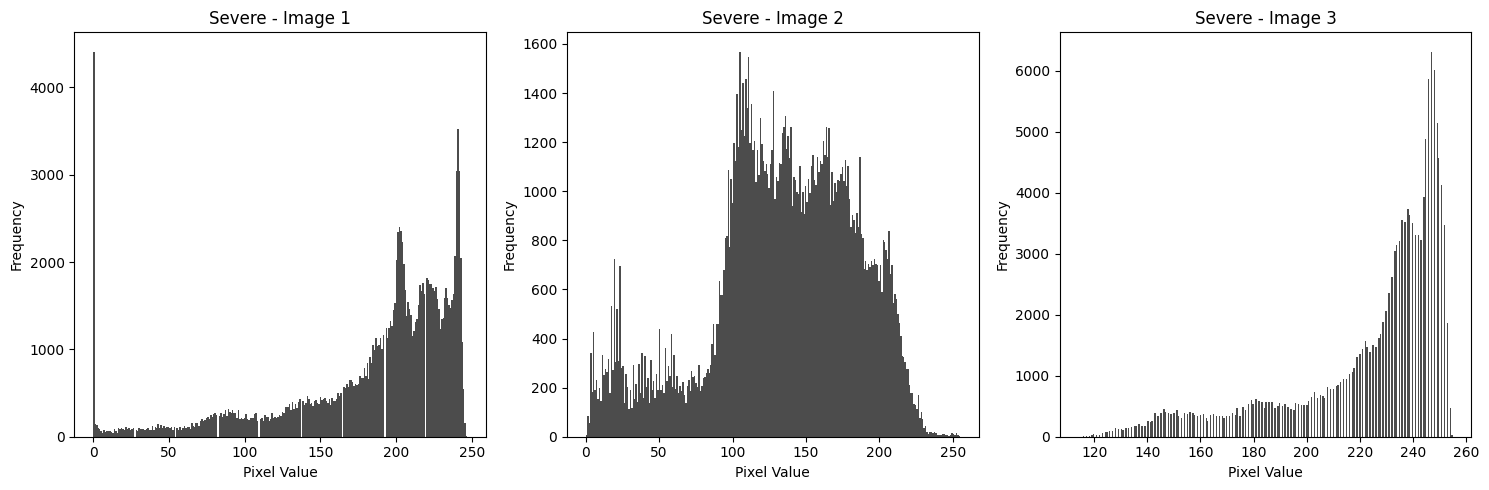

In [15]:
for label in df['label'].unique():
    print(f"Plotting histograms for class: {label}")
    plot_histograms_for_class(df, label, num_images=3)

In [16]:
# Function to calculate aspect ratio for each image
def calculate_aspect_ratio(image):
    height, width, _ = image.shape
    return width / height

# Apply the function to each image in the DataFrame
df['aspect_ratio'] = df['image'].apply(lambda x: calculate_aspect_ratio(np.array(x)))

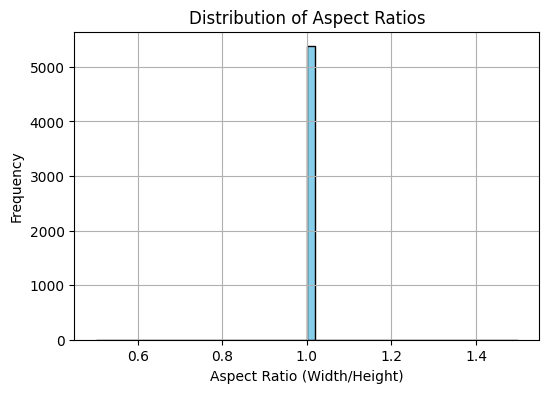

In [17]:
# Plot aspect ratios
plt.figure(figsize=(6, 4))
df['aspect_ratio'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Aspect Ratios')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.show()

In [53]:
def calculate_variability(image):
    # Pastikan image dalam format array 0-255
    # image = np.array(image) * 255
    image = image.astype(np.uint8)

    # Konversi ke grayscale manual dengan rata-rata channel
    gray = np.mean(image, axis=2)

    # Hitung laplacian menggunakan scipy
    laplacian = ndimage.laplace(gray)

    # Varians dari laplacian sebagai ukuran variabilitas
    return laplacian.var()

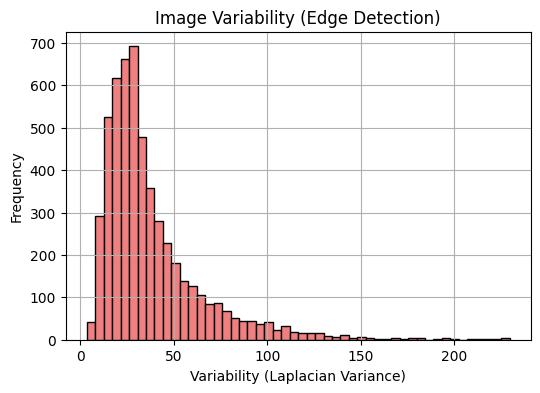

In [54]:
# Apply the function to each image in the DataFrame
df['variability'] = df['image'].apply(lambda x: calculate_variability(x))

# Plot variability (Laplacian variance) for the images
plt.figure(figsize=(6, 4))
df['variability'].hist(bins=50, color='lightcoral', edgecolor='black')
plt.title('Image Variability (Edge Detection)')
plt.xlabel('Variability (Laplacian Variance)')
plt.ylabel('Frequency')
plt.show()

In [20]:
df['height'] = df['image'].apply(lambda img: img.shape[0])
df['width'] = df['image'].apply(lambda img: img.shape[1])
df['resolution'] = df['width'] * df['height']

## Modelling

In [6]:
X = np.array(df['image'].tolist())  # Pastikan image-nya list of array
y = df['label'].values              # Label string

In [7]:
np.unique(y)

array(['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe'], dtype=object)

In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(y_encoded)
# y_onehot = to_categorical(y_encoded)
# print(y_onehot)

[0 0 0 ... 4 4 4]


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y  # stratify biar proporsi label tetap
)

In [10]:
print(f"Total data     : {len(df)}")
print(f"Train samples  : {len(X_train)}")
print(f"Val samples    : {len(X_val)}")

Total data     : 5375
Train samples  : 4568
Val samples    : 807


#### Function

In [11]:
def plot_history_curve(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss (left)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='tab:red', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', color='tab:orange', linewidth=2)
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot Accuracy (right)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='tab:green', linewidth=2)
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


In [12]:
def generate_callbacks(model_name, min_lr=1e-6):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'{model_name}.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=min_lr,
            verbose=1
        ),
        CSVLogger(f'{model_name}.csv')
    ]

In [13]:
def evaluate_classification_model(y_true, y_pred, class_names):
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print metrics
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [14]:
metrics=[
    'accuracy'#,
    # Precision(name='precision'),
    # Recall(name='recall'),
    # AUC(name='roc_auc')
]

In [55]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    RandomContrast(0.1),
    RandomBrightness(0.1),
    Rescaling(1./255)
], name="data_augmentation")

#### [B] Baseline Model: AlexNet

##### AlexNet1

In [56]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = Conv2D(96, kernel_size=(11,11), strides=4, activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

x = Conv2D(256, kernel_size=(5,5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

x = Conv2D(384, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(384, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)  # ubah 5 jadi jumlah kelas kamu

alexnet1 = Model(inputs=inputs, outputs=outputs)

In [57]:
optimizer = RMSprop(learning_rate=1e-4)


alexnet1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metrics)
alexnet1.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,767,493 (178.40 MB)

 Trainable params: 46,767,493 (178.40 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
callback1 = generate_callbacks('alexnet1')

history1 = alexnet1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callback1
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.2101 - loss: 4.5872
Epoch 1: val_loss improved from inf to 1.66812, saving model to alexnet1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.2100 - loss: 4.5715 - val_accuracy: 0.1958 - val_loss: 1.6681 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.1949 - loss: 1.6245
Epoch 2: val_loss improved from 1.66812 to 1.60814, saving model to alexnet1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.1949 - loss: 1.6245 - val_accuracy: 0.1958 - val_loss: 1.6081 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.2037 - loss: 1.6146
Epoch 3: val_loss improved from 1.60814 to 1.59291, saving model to alexnet1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.2038 - loss: 1.6146 - val_accuracy: 0.2441 - val_loss: 1.5929 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step

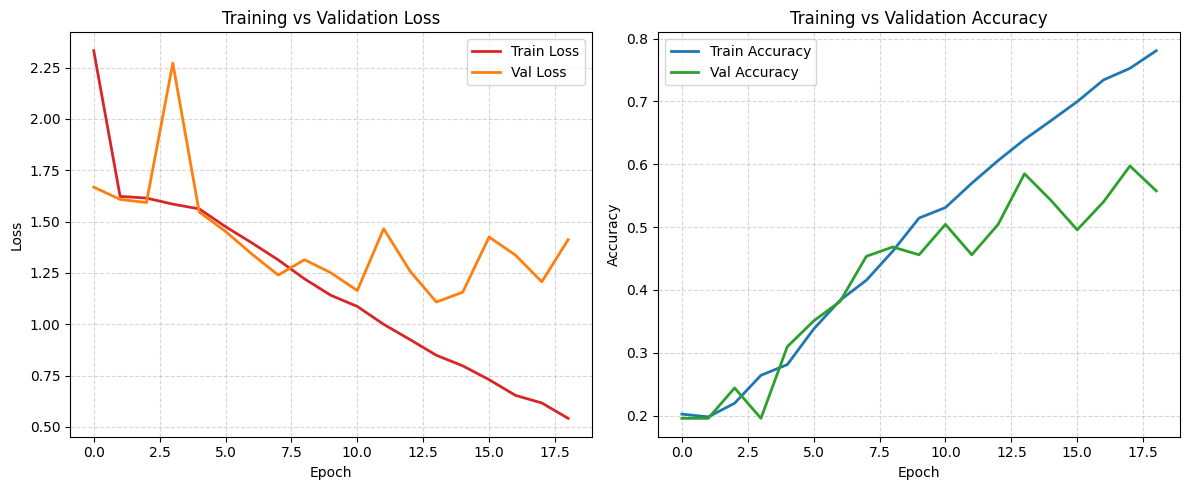

In [59]:
plot_history_curve(history1)

#### [C] Modified Model

##### AlexNet 2 (Adam)

In [60]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

# Conv Layer 1
x = Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu',
           kernel_regularizer=regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

# Conv Layer 2
x = Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

# Conv Layer 3
x = Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# Conv Layer 4
x = Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# Conv Layer 5
x = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
outputs = Dense(5, activation='softmax')(x)

# Model
alexnet2 = Model(inputs=inputs, outputs=outputs)

In [61]:
optimizer = Adam(learning_rate=1e-4)

alexnet2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metrics)
alexnet2.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,772,997 (178.42 MB)

 Trainable params: 46,770,245 (178.41 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [62]:
callback2 = generate_callbacks('alexnet2')

history2 = alexnet2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callback2
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2434 - loss: 2.9790
Epoch 1: val_loss improved from inf to 1.86170, saving model to alexnet2.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.2435 - loss: 2.9745 - val_accuracy: 0.1970 - val_loss: 1.8617 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3054 - loss: 1.7625
Epoch 2: val_loss did not improve from 1.86170
143/143 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.3054 - loss: 1.7621 - val_accuracy: 0.1871 - val_loss: 2.6272 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3382 - loss: 1.5778
Epoch 3: val_loss did not improve from 1.86170
143/143 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.3382 - loss: 1.5777 - val_accuracy: 0.1995 - val_loss: 3.4232 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3636 - loss: 1.4531
Epoch 4: val_loss did not improve from 1.86170
14

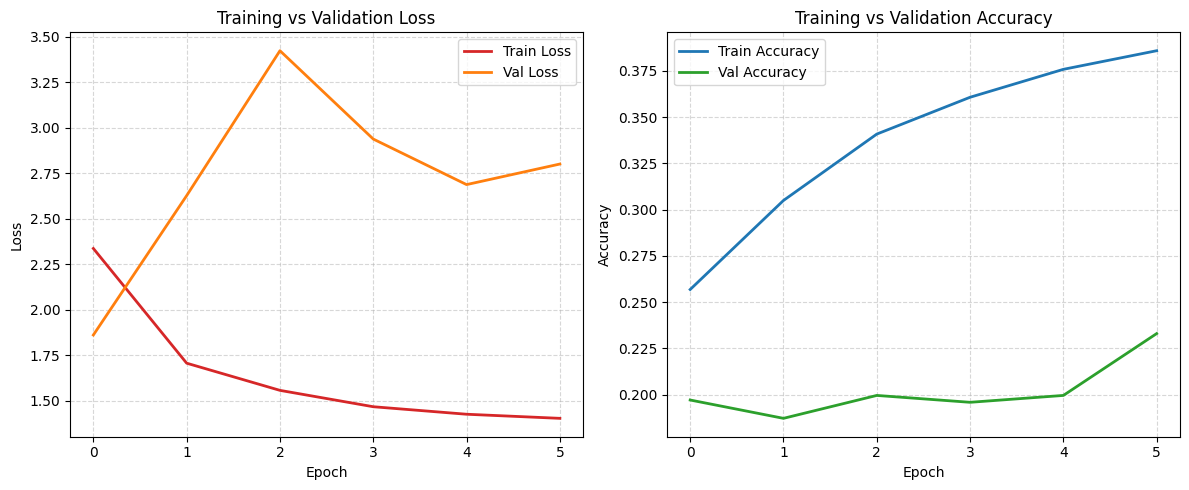

In [72]:
plot_history_curve(history2)

##### AlexNet 2 (RMSProp)

In [64]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

# Conv Layer 1
x = Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu',
           kernel_regularizer=regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

# Conv Layer 2
x = Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

# Conv Layer 3
x = Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# Conv Layer 4
x = Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# Conv Layer 5
x = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.3)(x)

# Output Layer
outputs = Dense(5, activation='softmax')(x)

# Model
alexnet2_2 = Model(inputs=inputs, outputs=outputs)

In [65]:
optimizer = RMSprop(learning_rate=1e-4)

alexnet2_2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metrics)
alexnet2_2.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,772,997 (178.42 MB)

 Trainable params: 46,770,245 (178.41 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [66]:
callback3 = generate_callbacks('alexnet2_2')

history3 = alexnet2_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callback2
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.2414 - loss: 4.1128
Epoch 1: val_loss did not improve from 1.86170
143/143 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.2414 - loss: 4.1029 - val_accuracy: 0.1983 - val_loss: 2.0520 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2813 - loss: 1.7848
Epoch 2: val_loss did not improve from 1.86170
143/143 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.2813 - loss: 1.7844 - val_accuracy: 0.2057 - val_loss: 2.0772 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3218 - loss: 1.5987
Epoch 3: val_loss did not improve from 1.86170
143/143 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.3218 - loss: 1.5986 - val_accuracy: 0.1970 - val_loss: 2.1942 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3460 - loss: 1.5081
Epoch 4: val_loss did not improve from 1.86170
143/143 ━━━━━━━━━━━━━━━━━━━━ 20

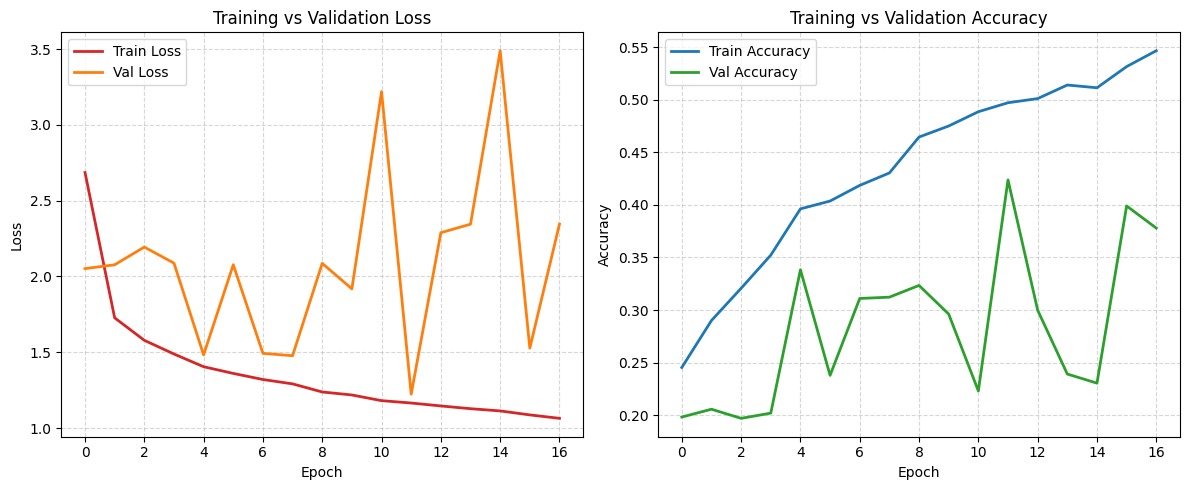

In [ ]:
plot_history_curve(history3)

##### DenseNet1

In [ ]:
# Input Layer
inputs = Input(shape=(224, 224, 3))  # Kalau grayscale, konversi dulu ke RGB 3-channel
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)

# Base Model - DenseNet121
base_model = DenseNet121(include_top=False, weights=None, input_tensor=x)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(5, activation='softmax')(x)  # Ganti 5 sesuai jumlah kelas

# Final Model
densenet1 = Model(inputs=inputs, outputs=outputs)

In [69]:
# Compile
optimizer = RMSprop(learning_rate=1e-4)
densenet1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metrics)

In [70]:
callback4 = generate_callbacks('densenet1', 1e-7)

history4 = densenet1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=42,
    callbacks=callback4
)

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2372 - loss: 1.7151
Epoch 1: val_loss improved from inf to 1.63240, saving model to densenet1.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 1167s 10s/step - accuracy: 0.2373 - loss: 1.7149 - val_accuracy: 0.1958 - val_loss: 1.6324 - learning_rate: 1.0000e-04
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2642 - loss: 1.6599
Epoch 2: val_loss did not improve from 1.63240
109/109 ━━━━━━━━━━━━━━━━━━━━ 1020s 9s/step - accuracy: 0.2644 - loss: 1.6596 - val_accuracy: 0.2020 - val_loss: 1.9498 - learning_rate: 1.0000e-04
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3173 - loss: 1.5186 
Epoch 3: val_loss did not improve from 1.63240
109/109 ━━━━━━━━━━━━━━━━━━━━ 1662s 15s/step - accuracy: 0.3174 - loss: 1.5182 - val_accuracy: 0.2032 - val_loss: 1.8307 - learning_rate: 1.0000e-04
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3661 - loss: 1.3969 
Epoch 4: val_loss did not improve from 

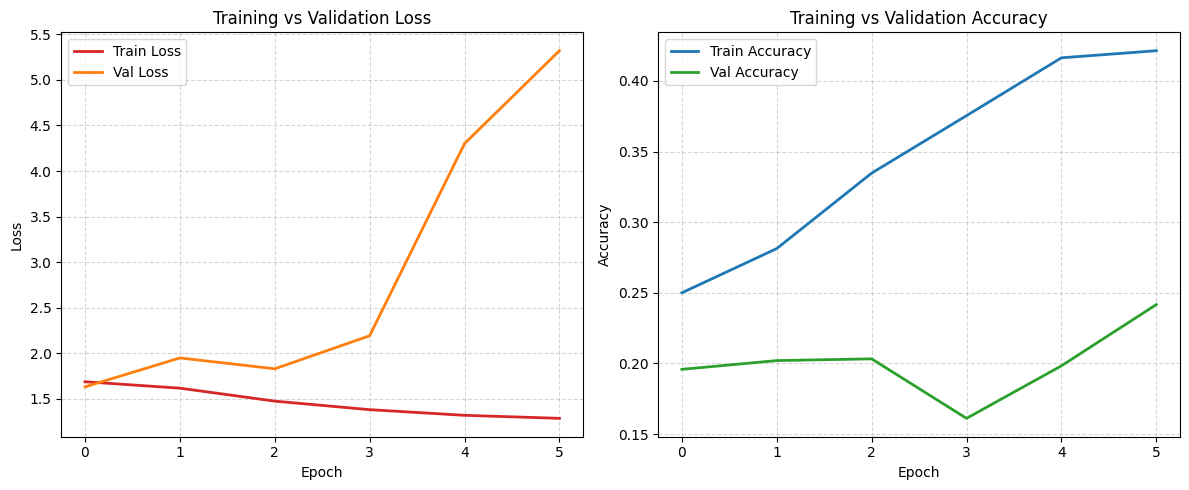

In [71]:
plot_history_curve(history4)

##### Model Aja

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Augmentasi data

x = Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)

outputs = Dense(5, activation="softmax")(x)

model_aja = Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = RMSprop(learning_rate=1e-4)

model_aja.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metrics)
model_aja.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1024)           │     3,277,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,903,573 (14.89 MB)

 Trainable params: 3,903,573 (14.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback5 = generate_callbacks('model_aja')

history5 = model_aja.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callback5
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2084 - loss: 1.6110
Epoch 1: val_loss did not improve from 1.22362
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 283ms/step - accuracy: 0.2085 - loss: 1.6110 - val_accuracy: 0.1958 - val_loss: 1.6097 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2052 - loss: 1.6084
Epoch 2: val_loss did not improve from 1.22362
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 349ms/step - accuracy: 0.2053 - loss: 1.6083 - val_accuracy: 0.2763 - val_loss: 1.6084 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.2142 - loss: 1.6059
Epoch 3: val_loss did not improve from 1.22362
143/143 ━━━━━━━━━━━━━━━━━━━━ 46s 320ms/step - accuracy: 0.2142 - loss: 1.6059 - val_accuracy: 0.2763 - val_loss: 1.5976 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2183 - loss: 1.5995
Epoch 4: val_loss did not improve from 1.22362
143/143 ━━━━━━━━

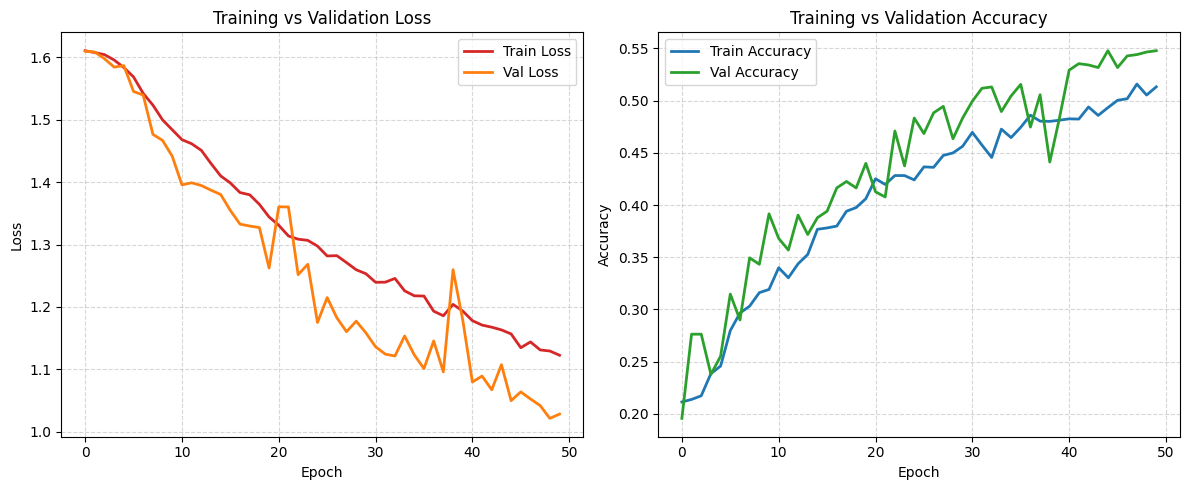

In [ ]:
plot_history_curve(history5)

In [ ]:
history5 = model_aja.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callback5
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5257 - loss: 1.1182
Epoch 1: val_loss improved from inf to 1.04121, saving model to model_aja.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.5256 - loss: 1.1183 - val_accuracy: 0.5502 - val_loss: 1.0412 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.5345 - loss: 1.0939
Epoch 2: val_loss improved from 1.04121 to 1.04121, saving model to model_aja.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - accuracy: 0.5344 - loss: 1.0940 - val_accuracy: 0.5452 - val_loss: 1.0412 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5036 - loss: 1.1234
Epoch 3: val_loss improved from 1.04121 to 1.01871, saving model to model_aja.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 324ms/step - accuracy: 0.5036 - loss: 1.1233 - val_accuracy: 0.5489 - val_loss: 1.0187 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3

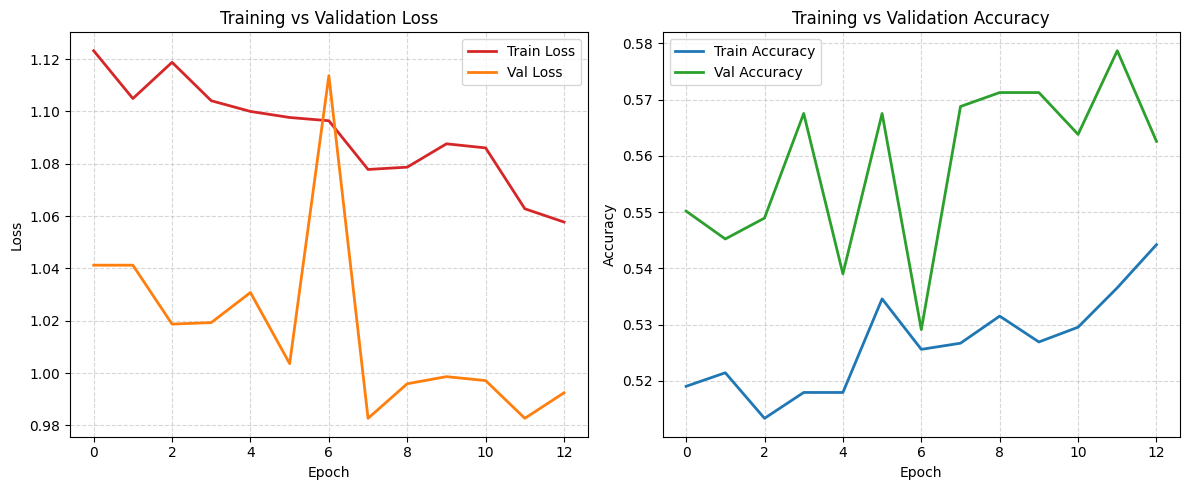

In [ ]:
plot_history_curve(history5)

In [ ]:
# Input model dengan shape (224, 224, 3)
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Augmentasi data

x = Conv2D(filters=8, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)

outputs = Dense(5, activation="softmax")(x)

model_aja = Model(inputs=inputs, outputs=outputs)

In [91]:
optimizer = RMSprop(learning_rate=1e-4)

model_aja.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metrics)
model_aja.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1024)           │     3,277,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,903,573 (14.89 MB)

 Trainable params: 3,903,573 (14.89 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
callback5 = generate_callbacks('model_aja')

history5 = model_aja.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callback5
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2084 - loss: 1.6110
Epoch 1: val_loss did not improve from 1.22362
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 283ms/step - accuracy: 0.2085 - loss: 1.6110 - val_accuracy: 0.1958 - val_loss: 1.6097 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2052 - loss: 1.6084
Epoch 2: val_loss did not improve from 1.22362
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 349ms/step - accuracy: 0.2053 - loss: 1.6083 - val_accuracy: 0.2763 - val_loss: 1.6084 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.2142 - loss: 1.6059
Epoch 3: val_loss did not improve from 1.22362
143/143 ━━━━━━━━━━━━━━━━━━━━ 46s 320ms/step - accuracy: 0.2142 - loss: 1.6059 - val_accuracy: 0.2763 - val_loss: 1.5976 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2183 - loss: 1.5995
Epoch 4: val_loss did not improve from 1.22362
143/143 ━━━━━━━━

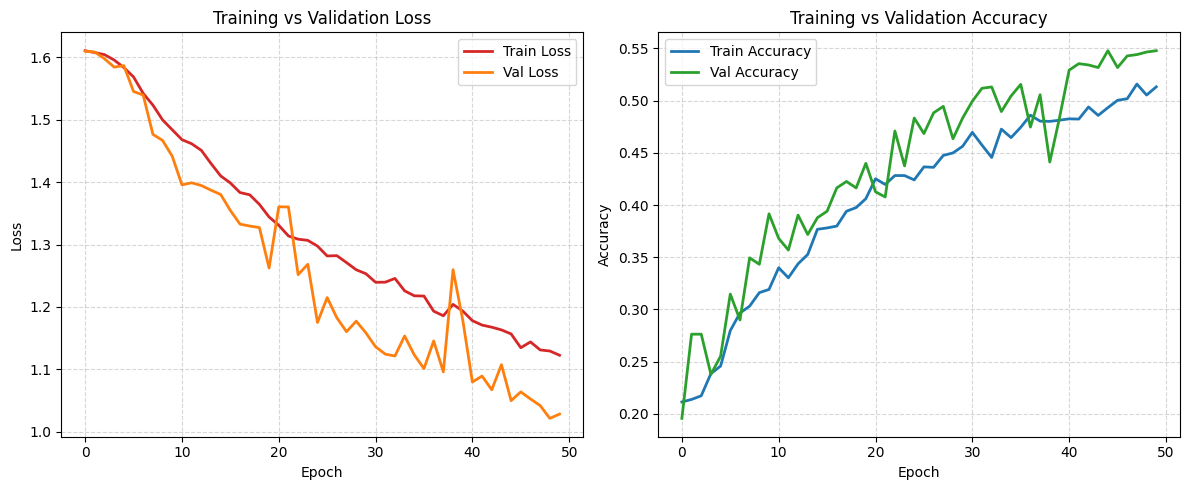

In [93]:
plot_history_curve(history5)

In [94]:
history5 = model_aja.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callback5
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5257 - loss: 1.1182
Epoch 1: val_loss improved from inf to 1.04121, saving model to model_aja.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.5256 - loss: 1.1183 - val_accuracy: 0.5502 - val_loss: 1.0412 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.5345 - loss: 1.0939
Epoch 2: val_loss improved from 1.04121 to 1.04121, saving model to model_aja.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - accuracy: 0.5344 - loss: 1.0940 - val_accuracy: 0.5452 - val_loss: 1.0412 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5036 - loss: 1.1234
Epoch 3: val_loss improved from 1.04121 to 1.01871, saving model to model_aja.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 324ms/step - accuracy: 0.5036 - loss: 1.1233 - val_accuracy: 0.5489 - val_loss: 1.0187 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3

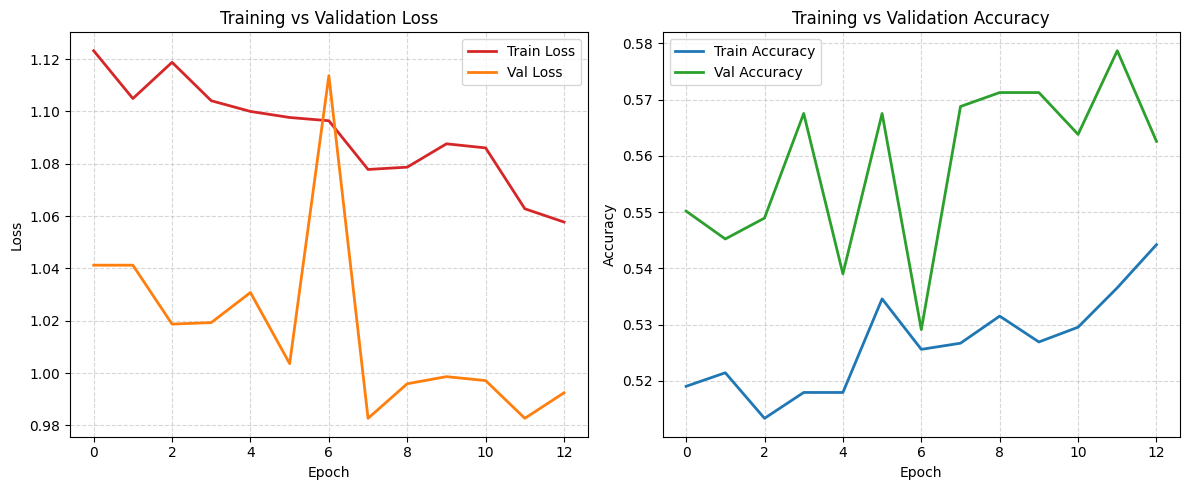

In [95]:
plot_history_curve(history5)

##### Hybrid Model

In [105]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Augmentasi data

# Conv Layer 1
x = Conv2D(32, kernel_size=(6, 6), strides=3, padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

# Conv Layer 2
x = Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

# Conv Layer 3
x = Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Conv Layer 4
x = Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Conv Layer 5
x = Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)

# Output Layer
outputs = Dense(5, activation="softmax")(x)

# Build the model
hybrid_model = Model(inputs=inputs, outputs=outputs)

In [106]:
optimizer = RMSprop(learning_rate=1e-4)

hybrid_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metrics)
hybrid_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 75, 75, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 37, 37, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,229,477 (16.13 MB)

 Trainable params: 4,229,477 (16.13 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
callback6 = generate_callbacks('hybrid_model')

history6 = hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callback6
)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.2063 - loss: 1.6114
Epoch 1: val_loss improved from inf to 1.60856, saving model to hybrid_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 305ms/step - accuracy: 0.2063 - loss: 1.6114 - val_accuracy: 0.2156 - val_loss: 1.6086 - learning_rate: 1.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.2109 - loss: 1.6094
Epoch 2: val_loss improved from 1.60856 to 1.60828, saving model to hybrid_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 283ms/step - accuracy: 0.2109 - loss: 1.6094 - val_accuracy: 0.2156 - val_loss: 1.6083 - learning_rate: 1.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.2075 - loss: 1.6092
Epoch 3: val_loss improved from 1.60828 to 1.60808, saving model to hybrid_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 271ms/step - accuracy: 0.2076 - loss: 1.6092 - val_accuracy: 0.2156 - val_loss: 1.6081 - learning_rate: 1.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━

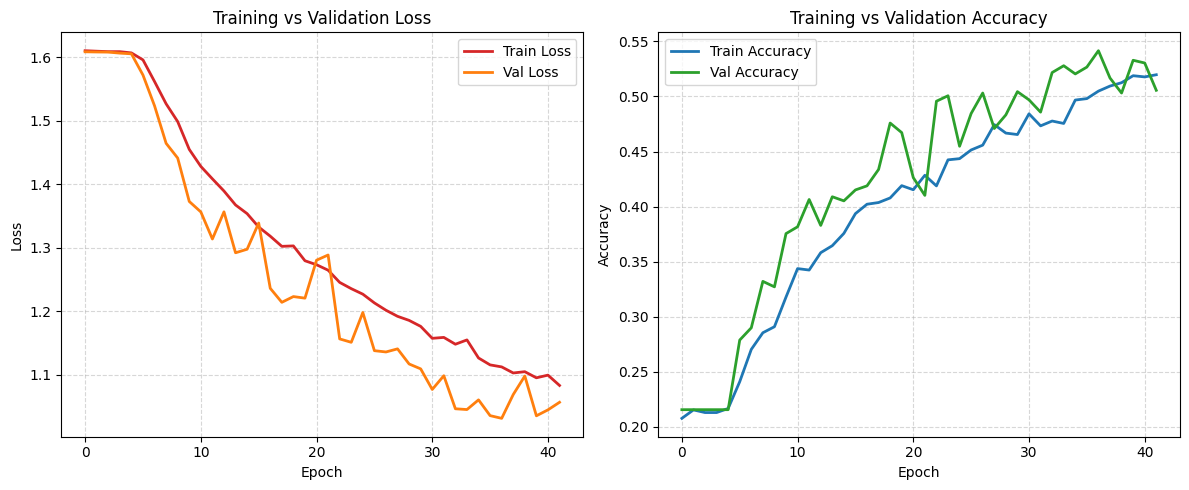

In [110]:
plot_history_curve(history6)

## Testing

In [73]:
# Pastikan fungsi load_images_from_directory sudah tersedia
test_image_data, test_labels, test_file_paths = load_images_from_directory(
    "C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/test"
)

Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/test\Doubtful\1_Doubtful_1.png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/test\Doubtful\1_Doubtful_10.png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/test\Doubtful\1_Doubtful_100.png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/test\Doubtful\1_Doubtful_101.png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/test\Doubtful\1_Doubtful_102.png
Processing image: C:/Users/User/OneDrive - Gabriella Clairine/Documents/BINUS/Semester 4/UTS/DL/UTSSSSSSSS DLL/No 2/Dataset 2B/test\Doubtful\1_Doubtful_103.png
Processing image: C:/Users/User/OneDrive - 

In [ ]:
df_test = pd.DataFrame({
    'image': list(test_image_data),  # Images as arrays
    'label': test_labels,            # Filenames for images
    'file_path': test_file_paths     # File paths for images
})
df_test.head()

,image,label,file_path
0,"[[[148.0, 148.0, 148.0], [146.0, 146.0, 146.0]...",Doubtful,C:/Users/User/OneDrive - Gabriella Clairine/Do...
1,"[[[76.0, 76.0, 76.0], [81.0, 81.0, 81.0], [83....",Doubtful,C:/Users/User/OneDrive - Gabriella Clairine/Do...
2,"[[[141.0, 141.0, 141.0], [140.0, 140.0, 140.0]...",Doubtful,C:/Users/User/OneDrive - Gabriella Clairine/Do...
3,"[[[104.0, 104.0, 104.0], [107.0, 107.0, 107.0]...",Doubtful,C:/Users/User/OneDrive - Gabriella Clairine/Do...
4,"[[[175.0, 175.0, 175.0], [177.0, 177.0, 177.0]...",Doubtful,C:/Users/User/OneDrive - Gabriella Clairine/Do...


In [75]:
X_test = np.array(test_image_data)
y_test = np.array(test_labels)

In [76]:
y_test_encoded = le.transform(y_test)

In [77]:
class_names = le.classes_

#### AlexNet Prediction and Evaluation

##### AlexNet1

In [37]:
alexnet1 = load_model('alexnet1.keras')

In [78]:
y_pred_probs1 = alexnet1.predict(X_test)
y_pred1 = np.argmax(y_pred_probs1, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step


Accuracy : 0.4949
Precision: 0.4790
Recall   : 0.4949
F1-Score : 0.4766

Classification Report:
              precision    recall  f1-score   support

    Doubtful       0.37      0.21      0.27       117
        Mild       0.36      0.38      0.37       117
    Moderate       0.46      0.35      0.40       117
      Normal       0.46      0.66      0.55       118
      Severe       0.74      0.86      0.80       117

    accuracy                           0.49       586
   macro avg       0.48      0.49      0.48       586
weighted avg       0.48      0.49      0.48       586



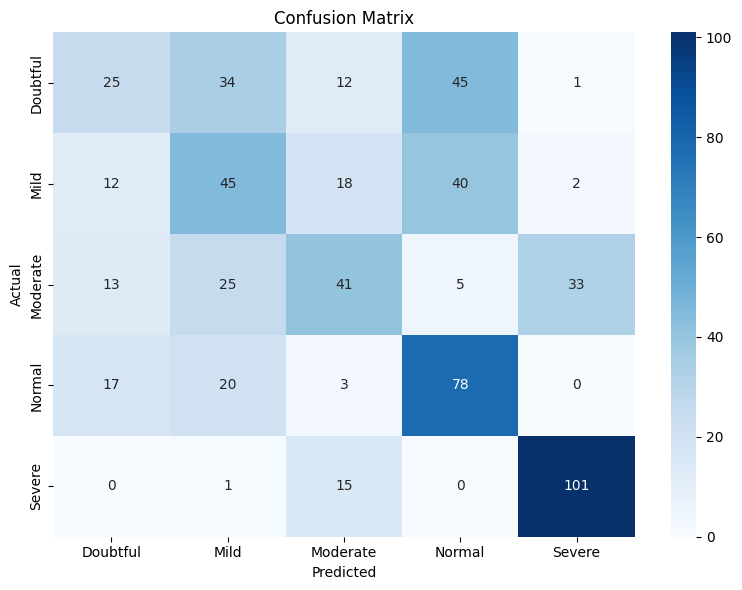

In [79]:
evaluate_classification_model(y_test_encoded, y_pred1, class_names)

##### AlexNet2 (Adam)

In [42]:
alexnet2 = load_model('alexnet2.keras')

In [80]:
y_pred_probs2 = alexnet2.predict(X_test)
y_pred2 = np.argmax(y_pred_probs2, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step


c:\Users\User\.conda\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\.conda\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\.conda\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Accuracy : 0.1928
Precision: 0.0392
Recall   : 0.1928
F1-Score : 0.0652

Classification Report:
              precision    recall  f1-score   support

    Doubtful       0.00      0.00      0.00       117
        Mild       0.00      0.00      0.00       117
    Moderate       0.00      0.00      0.00       117
      Normal       0.19      0.96      0.32       118
      Severe       0.00      0.00      0.00       117

    accuracy                           0.19       586
   macro avg       0.04      0.19      0.06       586
weighted avg       0.04      0.19      0.07       586



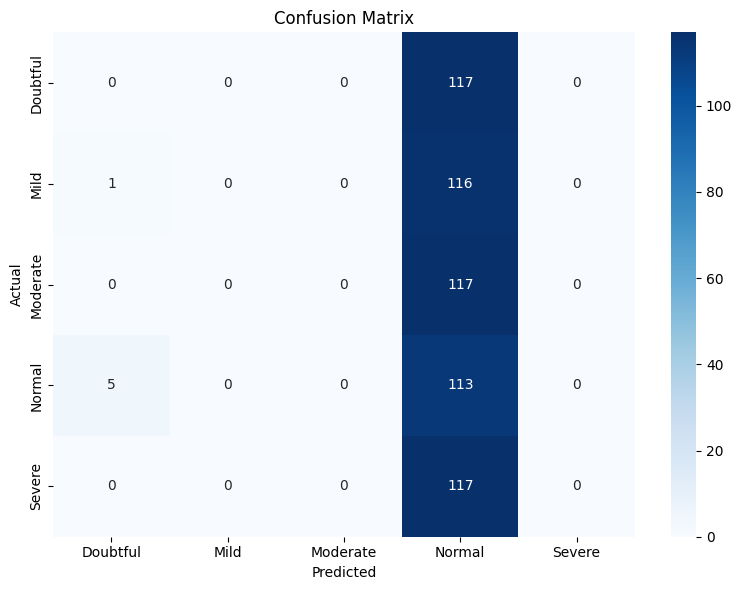

In [81]:
evaluate_classification_model(y_test_encoded, y_pred2, class_names)

##### AlexNet2 (RMSProp)

In [ ]:
alexnet2_2 = load_model('alexnet2_2.keras')

In [82]:
y_pred_probs3 = alexnet2_2.predict(X_test)
y_pred3 = np.argmax(y_pred_probs3, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step


Accuracy : 0.3345
Precision: 0.4809
Recall   : 0.3345
F1-Score : 0.3000

Classification Report:
              precision    recall  f1-score   support

    Doubtful       0.44      0.09      0.15       117
        Mild       0.26      0.68      0.38       117
    Moderate       0.32      0.54      0.40       117
      Normal       0.65      0.11      0.19       118
      Severe       0.73      0.26      0.38       117

    accuracy                           0.33       586
   macro avg       0.48      0.33      0.30       586
weighted avg       0.48      0.33      0.30       586



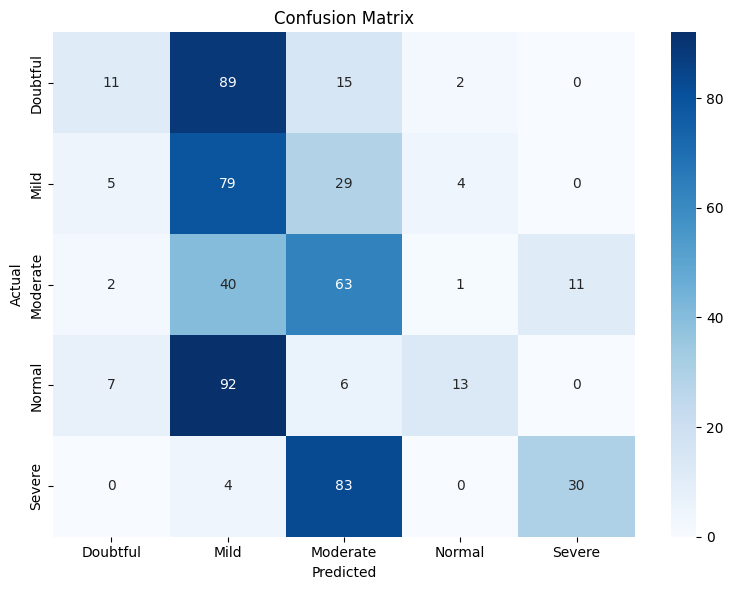

In [83]:
evaluate_classification_model(y_test_encoded, y_pred3, class_names)

### DenseNet Prediction and Evaluation

##### DenseNet1

In [84]:
y_pred_probs4 = densenet1.predict(X_test)
y_pred4 = np.argmax(y_pred_probs4, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step


Accuracy : 0.1997
Precision: 0.0399
Recall   : 0.1997
F1-Score : 0.0665

Classification Report:


c:\Users\User\.conda\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\.conda\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\.conda\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

              precision    recall  f1-score   support

    Doubtful       0.20      1.00      0.33       117
        Mild       0.00      0.00      0.00       117
    Moderate       0.00      0.00      0.00       117
      Normal       0.00      0.00      0.00       118
      Severe       0.00      0.00      0.00       117

    accuracy                           0.20       586
   macro avg       0.04      0.20      0.07       586
weighted avg       0.04      0.20      0.07       586



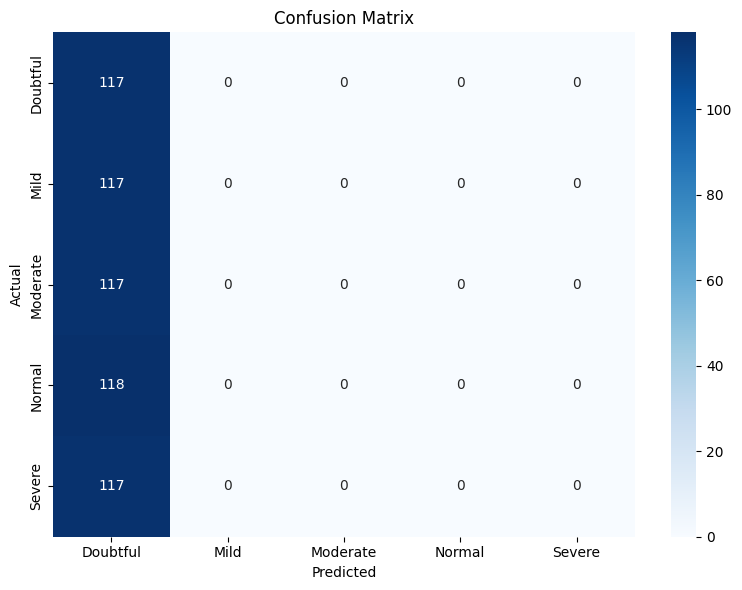

In [85]:
evaluate_classification_model(y_test_encoded, y_pred4, class_names)

### Model Aja

In [96]:
y_pred_probs5 = model_aja.predict(X_test)
y_pred5 = np.argmax(y_pred_probs5, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Accuracy : 0.4727
Precision: 0.4814
Recall   : 0.4727
F1-Score : 0.4550

Classification Report:
              precision    recall  f1-score   support

    Doubtful       0.33      0.27      0.30       117
        Mild       0.43      0.15      0.23       117
    Moderate       0.40      0.62      0.48       117
      Normal       0.45      0.63      0.52       118
      Severe       0.80      0.69      0.74       117

    accuracy                           0.47       586
   macro avg       0.48      0.47      0.45       586
weighted avg       0.48      0.47      0.45       586



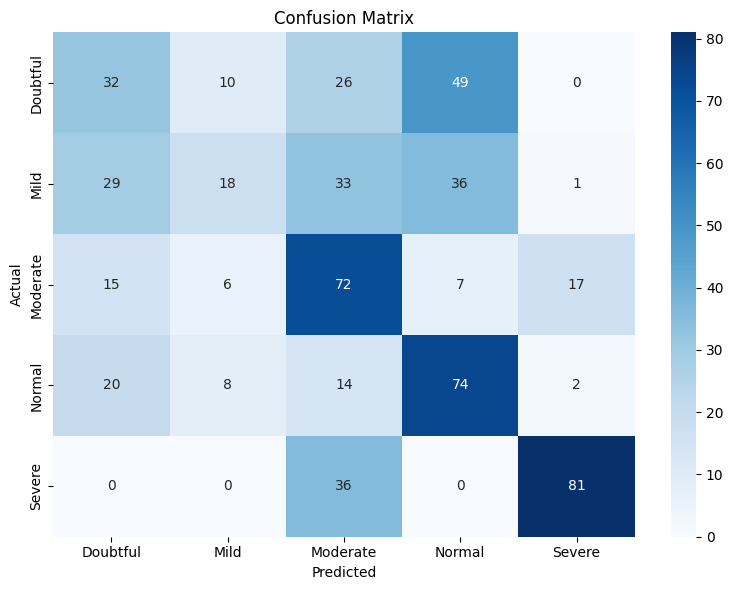

In [97]:
evaluate_classification_model(y_test_encoded, y_pred5, class_names)

### Hybrid Model

In [108]:
y_pred_probs6 = hybrid_model.predict(X_test)
y_pred6 = np.argmax(y_pred_probs6, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


Accuracy : 0.4403
Precision: 0.4083
Recall   : 0.4403
F1-Score : 0.3942

Classification Report:
              precision    recall  f1-score   support

    Doubtful       0.27      0.21      0.24       117
        Mild       0.27      0.03      0.05       117
    Moderate       0.41      0.54      0.46       117
      Normal       0.38      0.64      0.48       118
      Severe       0.71      0.78      0.74       117

    accuracy                           0.44       586
   macro avg       0.41      0.44      0.39       586
weighted avg       0.41      0.44      0.39       586



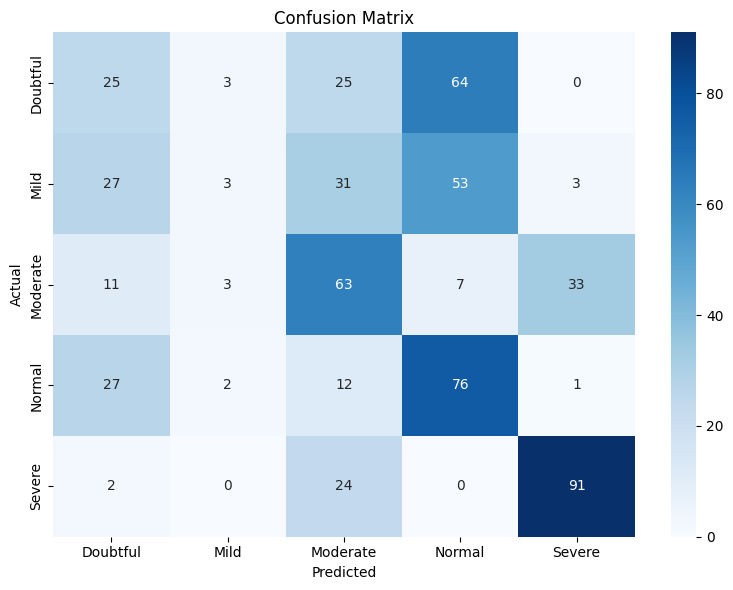

In [109]:
evaluate_classification_model(y_test_encoded, y_pred6, class_names)